# Benchmarking applying weights on mass library search

In this notebook, we explore the results of applying different weights on modified cosine similarity.

Imports

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import itertools

import sys

# Add the path to the src folder
sys.path.append("../../src/ms_similarity_metrics/")
# Import custom functions
from reformat_columns import reformat_columns

In [55]:
QUERY_DIR = '../../data/mod_cosine_queries/'
QUERY_PATH = 's3://enveda-data-user/chloe.engler/cosine_similarity/modified_cosine_queries/'
DATA_DIR = '../../data/'

"""Weights Files"""
UNWEIGHTED_FILE = 'no_weights/filtered_10_ppm'
WEIGHTED_FILES = ['our_weights/weighted_filtered_10_ppm', 
                'Stein_weights_0.6_3/10_ppm_stein_weights_0.6_3',
                'Stein_weights_0.5_1/10_ppm_stein_weights_0.5_1',
                'Stein_weights_0.5_2/10_ppm_stein_weights_0.5_2']
                # 'Stein_weights_0.6_2/10_ppm_stein_weights_0.6_2',
                # 'Stein_weights_0.53_1.3/10_ppm_stein_weights_0.53_1.3',]

NAME_DICT = {'our_weights/weighted_filtered_10_ppm': 'Our weights',
             'Stein_weights_0.6_3/10_ppm_stein_weights_0.6_3': 'Stein and Scott',
             'Stein_weights_0.5_1/10_ppm_stein_weights_0.5_1': 'Sokolow',
             'Stein_weights_0.5_2/10_ppm_stein_weights_0.5_2': 'Horai'}
            #  'Stein_weights_0.6_2/10_ppm_stein_weights_0.6_2': 'NIST',
            #  'Stein_weights_0.53_1.3/10_ppm_stein_weights_0.53_1.3': 'Kim',}
WEIGHTED_NAMES = [NAME_DICT[file] for file in WEIGHTED_FILES]

"""PPM Files"""
NAME_DICT_PPM = {'our_weights/weighted_filtered_10_ppm': 'Our weights 10 ppm',
             'our_weights/weighted_filtered_100_ppm': 'Our weights 100 ppm',
             'our_weights/weighted_filtered_5000_ppm': 'Our weights 5000 ppm',
             'no_weights/filtered_10_ppm': 'Unweighted 10 ppm',
             'no_weights/filtered_100_ppm': 'Unweighted 100 ppm',
             'no_weights/filtered_5000_ppm': 'Unweighted 5000 ppm',
             'Stein_weights_0.6_3/10_ppm_stein_weights_0.6_3': 'Stein 10 ppm',
             'Stein_weights_0.6_3/100_ppm_stein_weights_0.6_3': 'Stein 100 ppm',
             'Stein_weights_0.6_3/5000_ppm_stein_weights_0.6_3': 'Stein 5000 ppm',
             'Stein_weights_0.5_1/10_ppm_stein_weights_0.5_1': 'Sokolow 10 ppm',
             'Stein_weights_0.5_1/100_ppm_stein_weights_0.5_1': 'Sokolow 100 ppm',
             'Stein_weights_0.5_1/5000_ppm_stein_weights_0.5_1': 'Sokolow 5000 ppm'}

ALL_NAMES_PPM = NAME_DICT_PPM.values()
ALL_FILE_NAMES_PPM = NAME_DICT_PPM.keys()

CLASS_DICT_PPM = {NAME_DICT_PPM[file_name]: file_name.split('/')[0] for file_name in ALL_FILE_NAMES_PPM}

## Get queries (10ppm)

In [3]:
# Get the NIST23 queries
queries = pd.read_csv(f'{QUERY_PATH}{UNWEIGHTED_FILE}_with_stats.csv', index_col=0)

# weighted_queries = pd.read_csv(f'{QUERY_PATH}{WEIGHTED_FILE}_with_stats.csv', index_col=0)
# queries = pd.read_csv(f'{QUERY_DIR}{UNWEIGHTED_FILE}_with_stats.csv', index_col=0)
shared_queries = set(queries.wout_identifier)

# Get the NIST23 weighted queries
weighted_queries = {}
for name in tqdm(WEIGHTED_FILES):
    try:
        weighted_queries[NAME_DICT[name]] = pd.read_csv(f'{QUERY_DIR}{name}_with_stats.csv', index_col=0)
    except:
        weighted_queries[NAME_DICT[name]] = pd.read_csv(f'{QUERY_PATH}{name}_with_stats.csv', index_col=0)
        shared_queries = shared_queries.intersection(set(weighted_queries[NAME_DICT[name]].wout_identifier))

# Filter the queries to only include queries in both the weighted and unweighted queries
queries = queries[queries['wout_identifier'].isin(shared_queries)]
for name in WEIGHTED_NAMES:
    weighted_queries[name] = weighted_queries[name][weighted_queries[name]['wout_identifier'].isin(shared_queries)]

100%|██████████| 4/4 [02:42<00:00, 40.61s/it]


In [4]:
# Reformat columns in the query dataframe
queries = reformat_columns(['library_spectra_matches', 
                            'exact_matches', 
                            'nist_inchis', 
                            'smiles', 
                            'tanimoto'],
                            query_type='modified_cosine',
                            query_df=queries)
queries['tanimoto'] = queries['tanimoto'].apply(lambda x: x.astype(float))

# Reformat columns in the weightd query dataframe
for name in WEIGHTED_NAMES:
    weighted_queries[name] = reformat_columns(['library_spectra_matches', 
                                        'exact_matches', 
                                        'nist_inchis', 
                                        'smiles', 
                                        'tanimoto'],
                                        query_type='modified_cosine',
                                        query_df=weighted_queries[name])

  2%|▏         | 438/25437 [00:00<00:05, 4375.14it/s]

100%|██████████| 25437/25437 [00:00<00:00, 30064.89it/s]


## Get PPM benchmark results

In [5]:
# Get the NIST23 queries
# queries = pd.read_csv(f'{QUERY_PATH}{UNWEIGHTED_FILE}_with_stats.csv', index_col=0)
# weighted_queries = pd.read_csv(f'{QUERY_PATH}{WEIGHTED_FILE}_with_stats.csv', index_col=0)
queries_ppm = {}
for i,name in tqdm(enumerate(ALL_FILE_NAMES_PPM), total=len(ALL_FILE_NAMES_PPM)):
    try:
        queries_ppm[NAME_DICT_PPM[name]] = pd.read_csv(f'{QUERY_DIR}{name}_with_stats.csv', index_col=0)
    except:
        queries_ppm[NAME_DICT_PPM[name]] = pd.read_csv(f'{QUERY_PATH}{name}_with_stats.csv', index_col=0)
    if i == 0:
        shared_queries = set(queries_ppm[NAME_DICT_PPM[name]].wout_identifier)
    else:
        shared_queries = shared_queries.intersection(set(queries_ppm[NAME_DICT_PPM[name]].wout_identifier))

# Filter the queries to only include queries in both the weighted and unweighted queries
for name in ALL_NAMES_PPM:
    queries_ppm[name] = queries_ppm[name][queries_ppm[name]['wout_identifier'].isin(shared_queries)]

100%|██████████| 12/12 [18:04<00:00, 90.40s/it] 


In [6]:
# Reformat columns in the query dataframe
for name in ALL_NAMES_PPM:
    queries_ppm[name] = reformat_columns([
        'library_spectra_matches', 
        'exact_matches', 
        'nist_inchis', 
        'smiles', 
        'tanimoto'],
        query_type='modified_cosine',
        query_df=queries_ppm[name],
    )

  0%|          | 0/25437 [00:00<?, ?it/s]

100%|██████████| 25437/25437 [00:02<00:00, 8904.56it/s] 


Look at the the Precision@K across different ppm

In [80]:
# Create data frame
exact_matches_precision_ppm = pd.DataFrame(columns=ALL_NAMES_PPM, 
                                        index=['Top 1', 'Top 5'])
n_vals = [1, 5]

# Get precision of top n matches
for n in n_vals:
    for name in ALL_NAMES_PPM:
        exact_matches_precision_ppm.loc[f'Top {n}', name] =  queries_ppm[name]['exact_matches'].apply(lambda x: len(x[x < n])/n).mean()

exact_matches_precision_ppm = exact_matches_precision_ppm.T
exact_matches_precision_ppm['class'] = exact_matches_precision_ppm.index.map(CLASS_DICT_PPM)

In [81]:
exact_matches_precision_ppm['ppm'] = [
    name.split(' ')[-2]
    for name in ALL_NAMES_PPM
]
# Stylize names
exact_matches_precision_ppm['class'] = exact_matches_precision_ppm['class'].map({
    'our_weights': 'Our weights', 
    'no_weights': 'Unweighted', 
    'Stein_weights_0.6_3': 'Stein and Scott',
    'Stein_weights_0.5_1': 'Sokolow',
})

In [86]:
color_dict = {
    'Unweighted': '#eca86f', 
    'Our weights': '#e96f3d', 
    'Stein and Scott': '#d73c24',
    'Sokolow': '#0d2b53',
    'Horai': '#1d6d8b', 
    'NIST': '#2f8895', 
    'Kim': '#82a8a0',
}

In [82]:
exact_matches_precision_ppm

,Top 1,Top 5,class,ppm
Our weights 10 ppm,0.814797,0.746377,Our weights,10
Our weights 100 ppm,0.822385,0.751244,Our weights,100
Our weights 5000 ppm,0.761175,0.676361,Our weights,5000
Unweighted 10 ppm,0.80894,0.726241,Unweighted,10
Unweighted 100 ppm,0.806188,0.717946,Unweighted,100
Unweighted 5000 ppm,0.726344,0.593002,Unweighted,5000
Stein 10 ppm,0.77572,0.687432,Stein and Scott,10
Stein 100 ppm,0.76428,0.666329,Stein and Scott,100
Stein 5000 ppm,0.666706,0.540677,Stein and Scott,5000
Sokolow 10 ppm,0.824822,0.756339,Sokolow,10


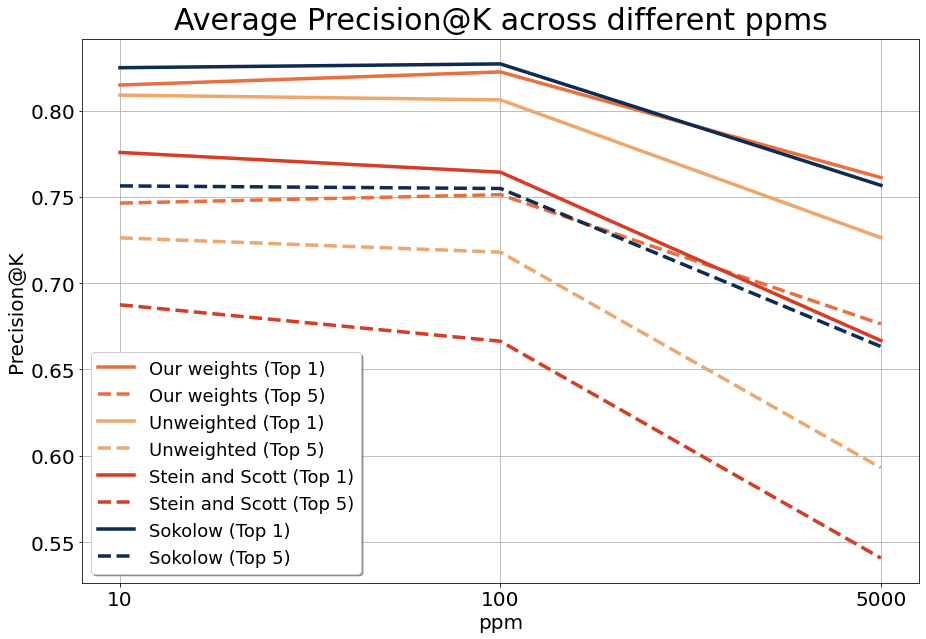

In [85]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10, forward=True)
            
for type in exact_matches_precision_ppm['class'].unique():

    for top in ['Top 1', 'Top 5']:
        # slice dataframe
        df = exact_matches_precision_ppm[exact_matches_precision_ppm['class'] == type]

        ax.plot(
            df.ppm,
            df[top],
            label=f'{type} ({top})',
            c=color_dict[type],
            ls="-" if '1' in top else '--',  # Marker for each top cutoff
            markersize=12,
            linewidth=3.5,
        )

ax.set_title('Average Precision@K across different ppms', pad=10)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
    
ax.title.set_fontsize(30)
plt.grid()

ax.set_xlabel("ppm")
ax.set_ylabel('Precision@K')

# ax.legend(bbox_to_anchor=(1., 1.05), fancybox=True, shadow=True, prop={'size': 14})
ax.legend(loc='best', fancybox=True, shadow=True, prop={'size': 18})
plt.show()

## Create figure 3

In [10]:
# Create dataframe for number of matches
num_matches = pd.DataFrame(columns=['num_queries_without_matches', 'average_num_matches', 'max_num_matches', 
                                    'average_num_exact_matches', 'num_queries_without_exact_matches'])
num_matches.loc['col_names'] = ['Any matches', 'Any matches', 'Any matches', 'Exact matches', 'Exact matches']

# Get number of matches per query
num_matches_list = queries.library_spectra_matches.apply(lambda x: len(x))
num_exact_matches = queries.exact_matches.apply(lambda x: len(x))
num_matches.loc['Unweighted'] = [len(num_matches_list[num_matches_list == 0]), 
                                    num_matches_list.mean(), 
                                    num_matches_list.max(),
                                    num_exact_matches.mean(),
                                    len(num_exact_matches[num_exact_matches == 0])]

# Get number of matches per query for each weighting method
for name in WEIGHTED_NAMES:
    num_matches_list = weighted_queries[name].library_spectra_matches.apply(lambda x: len(x))
    num_exact_matches = weighted_queries[name].exact_matches.apply(lambda x: len(x))
    num_matches.loc[name.split('/')[-1]] = [len(num_matches_list[num_matches_list == 0]),
                                            num_matches_list.mean(),
                                            num_matches_list.max(),
                                            num_exact_matches.mean(),
                                            len(num_exact_matches[num_exact_matches == 0])]

In [11]:
# Create data frame
column_names = [x.split('/')[-1] for x in WEIGHTED_NAMES] + ['Unweighted']
average_tanimoto_top_n = pd.DataFrame(columns=column_names, 
                                   index=['Top 1', 'Top 5', 'Top 10'])
n_vals = [1, 5, 10]

# Calculate average tanimoto score for top n results
for n in n_vals:
    average_tanimoto_top_n.loc[f'Top {n}','Unweighted'] = np.mean(list(itertools.chain.from_iterable([x[:n] for 
                                                                x in queries['tanimoto'] if len(x) > 0])))
    for name in WEIGHTED_NAMES:
        average_tanimoto_top_n.loc[f'Top {n}', name] = np.mean(list(itertools.chain.from_iterable([x[:n] for 
                                                                x in weighted_queries[name]['tanimoto'] if len(x) > 0])))

In [12]:
# Create data frame
column_names = WEIGHTED_NAMES + ['Unweighted']
exact_matches_precision = pd.DataFrame(columns=column_names, 
                                        index=['Top 1', 'Top 5', 'Top 10'])
n_vals = [1, 5, 10]

# Get precision of top n matches
for n in n_vals:
    exact_matches_precision.loc[f'Top {n}', 'Unweighted'] = queries['exact_matches'].apply(lambda x: len(x[x < n])/n).mean()
    for name in WEIGHTED_NAMES:
        exact_matches_precision.loc[f'Top {n}', name] =  weighted_queries[name]['exact_matches'].apply(lambda x: len(x[x < n])/n).mean()

In [13]:

# Get number of matches above a threshold
thresholds = [0.5, 0.7, 0.9]
threshold_df = pd.DataFrame(columns=thresholds)
for threshold in thresholds:
    threshold_df.loc['Unweighted', threshold] = queries.library_spectra_matches.apply(lambda x: len([y for y in x if y[1]> threshold])).mean()
    for name in WEIGHTED_NAMES:
        threshold_df.loc[name, threshold] = weighted_queries[name].library_spectra_matches.apply(lambda x: 
                                    len([y for y in x if y[1]> threshold])).mean()

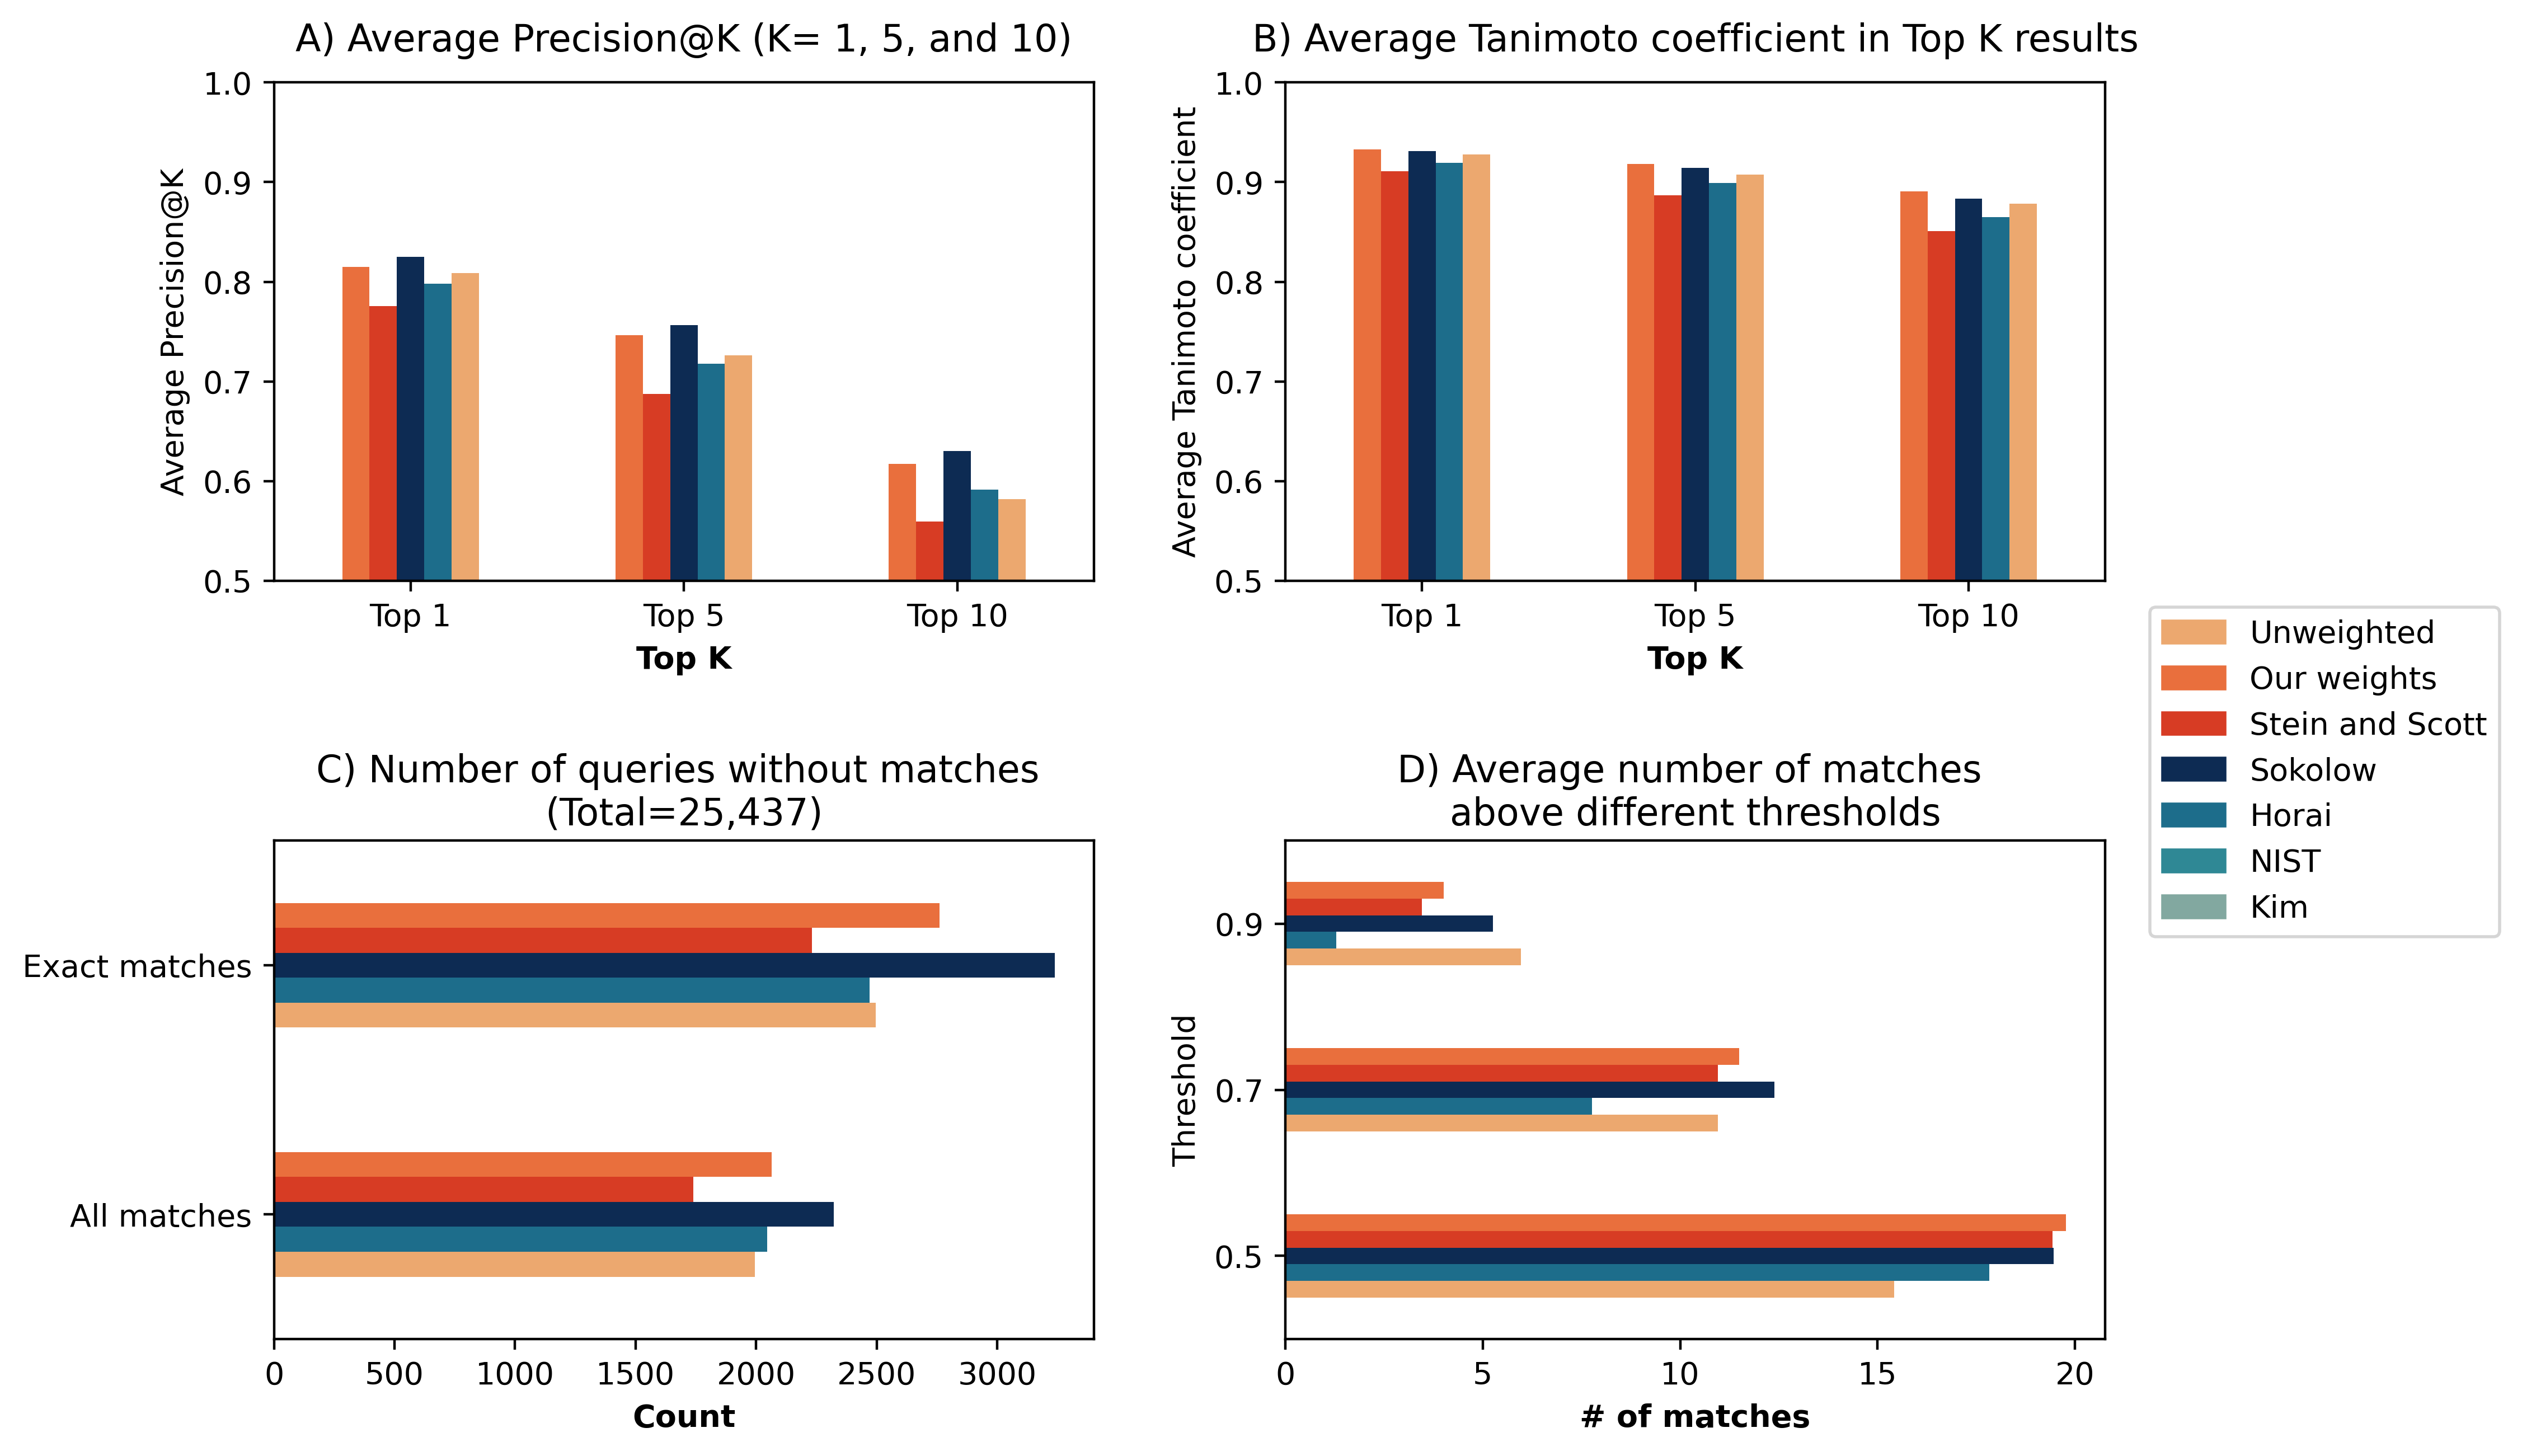

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7), dpi=400)

# Define handles
handles = []
for name in color_dict.keys():
    handles.append(mpatches.Patch(color=color_dict[name], label=name))

"""A) Panel: Average Precision@K"""""
exact_matches_precision.plot.bar(
    rot=0,
    ax=axes[0,0],
    color=color_dict,
    legend=False,
)
axes[0,0].set_title('A) Average Precision@K (K= 1, 5, and 10)', pad=10)
axes[0,0].set_ylabel('Average Precision@K')
axes[0,0].set_xlabel('Top K', fontweight='bold',)
axes[0,0].set_ylim(0.5, 1.0)

"""B) Panel: Tanimoto coefficients in Top K matches"""""
average_tanimoto_top_n.plot.bar(
    rot=0,
    color=color_dict,ax=axes[0,1],
    legend=False,
)
axes[0,1].set_title('B) Average Tanimoto coefficient in Top K results', pad=10)
axes[0,1].set_ylabel('Average Tanimoto coefficient')
axes[0,1].set_xlabel(
    'Top K',
    fontweight='bold',
)
axes[0,1].set_ylim(0.5, 1.0)


"""C) Panel: Number of queries without matches"""""
tmp_df = num_matches[['num_queries_without_matches', 'num_queries_without_exact_matches']].T
# Keep same order as in the other plots
tmp_df.columns = [
    'col_names', 'Unweighted', 'Horai', 'Sokolow', 'Stein and Scott', 'Our weights' 
]


tmp_df.plot.barh(
    color=color_dict,
    ax=axes[1,0],
    legend=False,
)
axes[1,0].set_title(f'C) Number of queries without matches \n(Total={queries.shape[0]:,})', pad=5)
axes[1,0].set_yticklabels(['All matches', 'Exact matches'])
axes[1,0].set_xlabel('Count', fontweight='bold')

del tmp_df

"""D) Panel: Average number of matches above thresholds"""""
tmp_df = threshold_df.T
# Keep same order as in the other plots
tmp_df.columns = [
    'Unweighted', 'Horai', 'Sokolow', 'Stein and Scott', 'Our weights' 
]

tmp_df.plot.barh(color=color_dict, ax=axes[1,1], legend=False)
axes[1,1].set_title(f'D) Average number of matches \nabove different thresholds', pad=5)
axes[1,1].set_ylabel('Threshold')
axes[1,1].set_xlabel('# of matches', fontweight='bold')

del tmp_df

# Add space between the two columns

plt.tight_layout(pad=2.5)
plt.legend(handles=[x for x in handles], bbox_to_anchor=(1.5, 1.5))
plt.show()

# Look at ranks of exact matches

### Look at ranks of exact matches

In [15]:
# Get all ranks of exact matches
all_ranks = list(itertools.chain(*list(queries['exact_matches'])))
all_ranks_weighted = {}
for name in WEIGHTED_NAMES:
    all_ranks_weighted[name] = list(itertools.chain(*list(weighted_queries[name]['exact_matches'])))

# Get highest rank of exact matches for each query
all_rank_1 = [x[0] for x in queries['exact_matches'] if len(x) > 0]
all_rank_1_weighted = {}
for name in WEIGHTED_NAMES:
    all_rank_1_weighted[name] = [x[0] for x in weighted_queries[name]['exact_matches'] if len(x) > 0]

#### Look at the percent of queries with an exact match in the top n matches

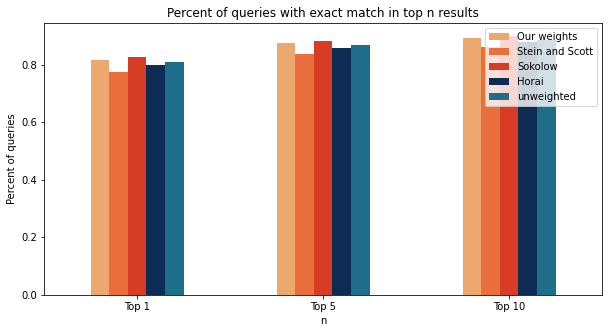

In [19]:
# Create data frame
column_names = WEIGHTED_NAMES + ['unweighted']
exact_matches_top_n = pd.DataFrame(columns=column_names, 
                                   index=['Top 1', 'Top 5', 'Top 10'])
n_vals = [1, 5, 10]

# Get percent of queries with exact match in top 5
for n in n_vals:
    exact_matches_top_n.loc[f'Top {n}', 'unweighted'] = queries.loc[queries['exact_matches'].apply(lambda x: min(x) \
                                                        if len(x) > 0 else np.nan)<n].shape[0] / queries.shape[0]
    for name in WEIGHTED_NAMES:
        exact_matches_top_n.loc[f'Top {n}', name] =  weighted_queries[name].loc[weighted_queries[name]['exact_matches'].apply(lambda x: min(x) \
                                                                    if len(x) > 0 else np.nan)<n].shape[0] / weighted_queries[name].shape[0]

# Create bar plot
exact_matches_top_n.plot.bar(figsize=(10,5), rot=0, color=['#eca86f', '#e96f3d', '#d73c24', '#0d2b53','#1d6d8b', '#2f8895', '#82a8a0'])
plt.title('Percent of queries with exact match in top n results')
plt.ylabel('Percent of queries')
plt.xlabel('n')
plt.show()


# Look at AUC-ROC scores

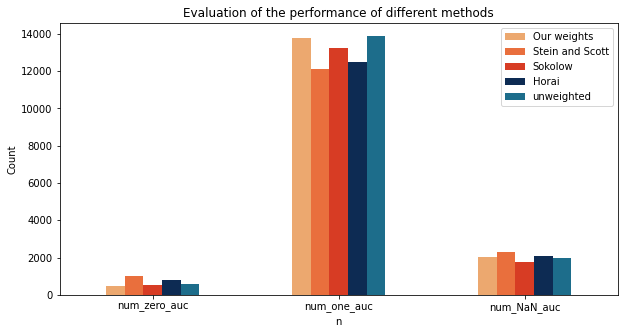

In [17]:
auc_scores = pd.DataFrame(index=['avg_auc', 
                                   'num_zero_auc',
                                   'num_one_auc',
                                   'num_NaN_auc'],
                          columns=column_names)

auc_scores['unweighted'] = [queries.auc.mean(), 
                            queries.auc.loc[queries.auc == 0].count(), 
                            queries.auc.loc[queries.auc == 1].count(),
                            queries.auc.isna().sum()]
for name in WEIGHTED_NAMES:
    auc_scores[name] = [weighted_queries[name].auc.mean(), 
                        weighted_queries[name].auc.loc[weighted_queries[name].auc == 0].count(), 
                        weighted_queries[name].auc.loc[weighted_queries[name].auc == 1].count(),
                        weighted_queries[name].auc.isna().sum()]

# Create bar plot
auc_scores.loc[['num_zero_auc','num_one_auc','num_NaN_auc']].plot.bar(figsize=(10,5), rot=0,
                color=['#eca86f', '#e96f3d', '#d73c24', '#0d2b53','#1d6d8b', '#2f8895', '#82a8a0'])

plt.title('Evaluation of the performance of different methods')
plt.ylabel('Count')
plt.xlabel('n')
plt.show()

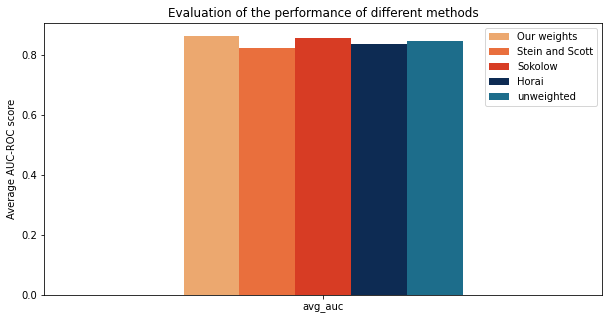

In [18]:
# Create bar plot
auc_scores.loc[['avg_auc']].plot.bar(figsize=(10,5), rot=0,
                color=['#eca86f', '#e96f3d', '#d73c24', '#0d2b53','#1d6d8b', '#2f8895', '#82a8a0']
)
plt.title('Evaluation of the performance of different methods')
plt.ylabel('Average AUC-ROC score')
plt.xlabel('')

plt.show()